**Imports**

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from reader import extract_all_data

**Collation of data**

In [2]:
curr_dir = os.getcwd()
data_folders = (name for name in os.listdir(".") if os.path.isdir(name))
data_files = {dir: (file for file in os.listdir(f'{curr_dir}/{dir}') if file.endswith('.csv')) for dir in data_folders}

In [5]:
# all_files = extract_all_data(data_files, curr_dir)

In [6]:
# all_files.write_csv('collated.csv')

**Unpivoting**

In [7]:
# collated = pl.read_csv(f'{curr_dir}/collated.csv')

In [8]:
# collated.head()

In [9]:
# unpivoted = collated.unpivot(
#     index = [x for x in collated.columns if ':' not in x],
#     on = [x for x in collated.columns if ':' in x],
#     variable_name='time',
#     value_name='energy_kw'
# )

In [10]:
# unpivoted.head()

In [ ]:
# unpivoted.write_csv('unpivoted.csv')

In [17]:
pl_df = pl.read_csv("unpivoted.csv")

#Create a datetime column
pl_df = pl_df.with_columns([
    (pl.col("Date") + " " + pl.col("time")).str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M").alias("Datetime")
])

# Filter out PV-related rows based on filename or building name
pv_keywords = ["pv"]

In [18]:
# Extracting date features
pl_df = pl_df.with_columns([
            pl.col("Datetime").dt.date().alias("Date"),
            pl.col("Datetime").dt.hour().alias("Hour"),
            pl.col("Datetime").dt.strftime("%H:%M").alias("time"),
            pl.col("Datetime").dt.year().alias("Year"),
            pl.col("Datetime").dt.month().alias("Month"),
            pl.col("Datetime").dt.strftime("%A").alias("Weekday"),
            pl.col("Datetime").dt.strftime("%A").is_in(["Saturday", "Sunday"]).alias("is_weekend"),
            pl.when(pl.col("Datetime").dt.strftime("%A").is_in(["Saturday", "Sunday"])) \
            .then(pl.lit("Weekend")) \
            .otherwise(pl.lit("Weekday")) \
            .alias("day_type")
])

# Filling nulls for energy and creating intermediate columns
pl_df = pl_df.with_columns([
            pl.when(pl.col("file_name").str.to_lowercase().str.contains("ashfield")) \
            .then(pl.lit("ashfield")) \
            .when(pl.col("file_name").str.to_lowercase().str.contains("engineering_engineering")) \
            .then(pl.lit("engineering_engineering")) \
            .otherwise(pl.col("building_name")) \
            .alias("building_v1"),

            pl.when(pl.col('energy_kw').is_not_null() & pl.col('energy_kw').is_not_nan()) \
            .then(pl.col('energy_kw')) \
            .otherwise(
                pl.col("energy_kw") \
                .filter(pl.col('energy_kw').is_not_null() & pl.col('energy_kw').is_not_nan()) \
                .median().over(["building_name", "Year"]) \
            ).alias("energy_kw")
        ])

In [40]:
pl_df = pl_df.with_columns([
            pl.col('energy_kw').sqrt().alias('energy_normal')
        ])

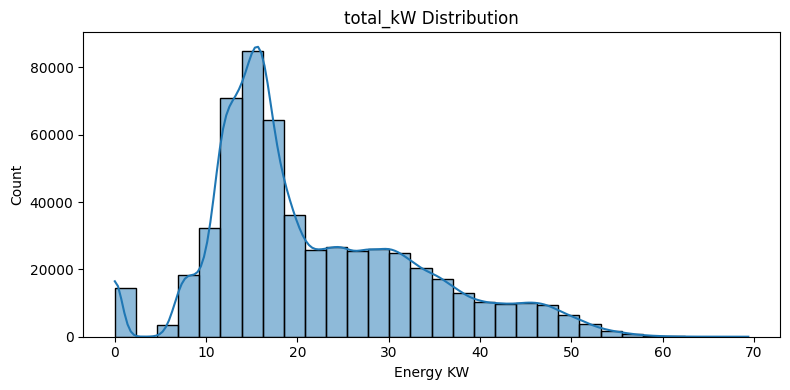

In [41]:
quinn_df = pl_df.filter(pl.col('building_name') == 'UCD - University College Dublin > Belfield > Quinn and Moore School of Business > Electricity > Quinn School Electricity (Includes SSOL & Moore)').to_pandas()

plt.figure(figsize=(8, 4))
sns.histplot(data=quinn_df, x="energy_kw", kde=True, bins=30)
plt.title(f"total_kW Distribution")
plt.xlabel("Energy KW")
plt.tight_layout()
plt.show()

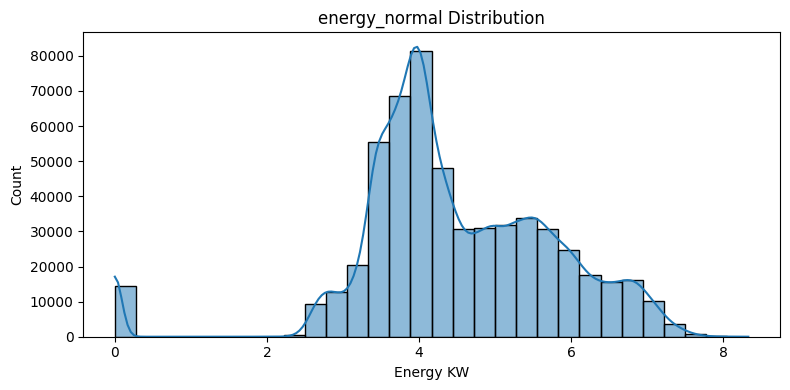

In [42]:
plt.figure(figsize=(8, 4))
sns.histplot(data=quinn_df, x="energy_normal", kde=True, bins=30)
plt.title(f"energy_normal Distribution")
plt.xlabel("Energy KW")
plt.tight_layout()
plt.show()

In [24]:
# Convert to Polars filtering syntax
pl_consumption_df = pl_df.filter(
    ~pl.col("file_name").str.to_lowercase().str.contains("|".join(pv_keywords)) &
    ~pl.col("building_name").str.to_lowercase().str.contains("|".join(pv_keywords))
)

pl_pv_df = pl_df.filter(
    pl.col("file_name").str.to_lowercase().str.contains("|".join(pv_keywords)) |
    pl.col("building_name").str.to_lowercase().str.contains("|".join(pv_keywords))
)

In [25]:
#Aggregate by Date, Building, and Day Type
pl_daily_summary = pl_consumption_df.group_by(["campus", "Date", "Month", "building_name", "day_type", "building_v1"]).agg([
    pl.col("energy_normal").sum().alias("total_kW"),
    pl.col("energy_normal").max().alias("peak_kW"),
    pl.col("energy_normal").mean().alias("avg_kW")
])

# Step 8: Calculate load factor
pl_daily_summary = pl_daily_summary.with_columns([
    ((pl.col("total_kW") * 0.25) / (pl.col("peak_kW") * 24)).alias("load_factor")
])

In [26]:
# pl_daily_summary.write_csv("daily_summary.csv")

In [27]:
# Set campus filter
target_campus = "Belfield"  # or "Blackrock", etc.

# Filter main DataFrame to target campus
pl_df_filtered = pl_consumption_df.filter(pl.col("campus") == target_campus)
pl_daily_summary_filtered = pl_daily_summary.filter(pl.col("campus") == target_campus)

# List of buildings in this campus
buildings = set(pl_df_filtered.select("building_name").unique().to_dict().get("building_name").to_list())

In [28]:
df_filtered = pl_df_filtered.to_pandas()
consumption_df = pl_consumption_df.to_pandas()
daily_summary_filtered = pl_daily_summary_filtered.to_pandas()
pv_df = pl_pv_df.to_pandas()

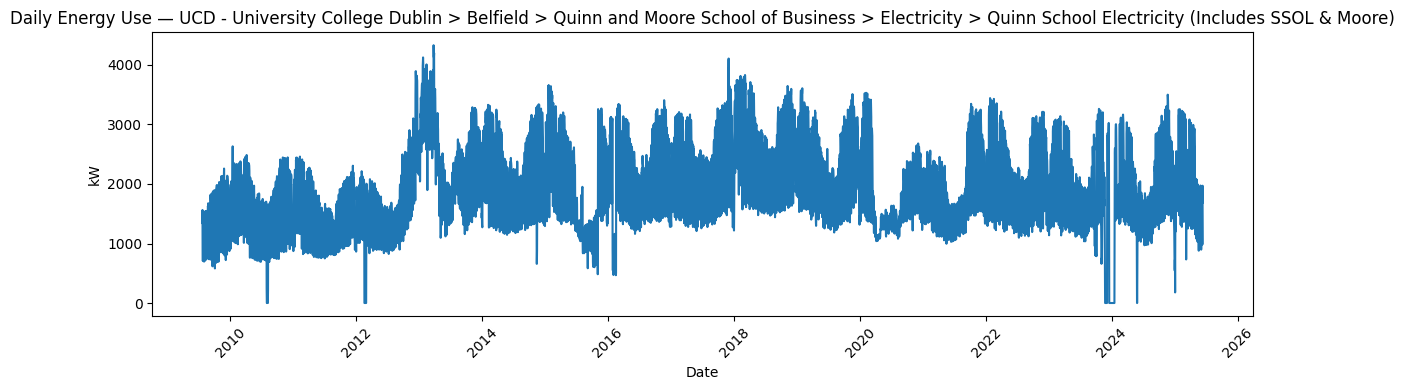

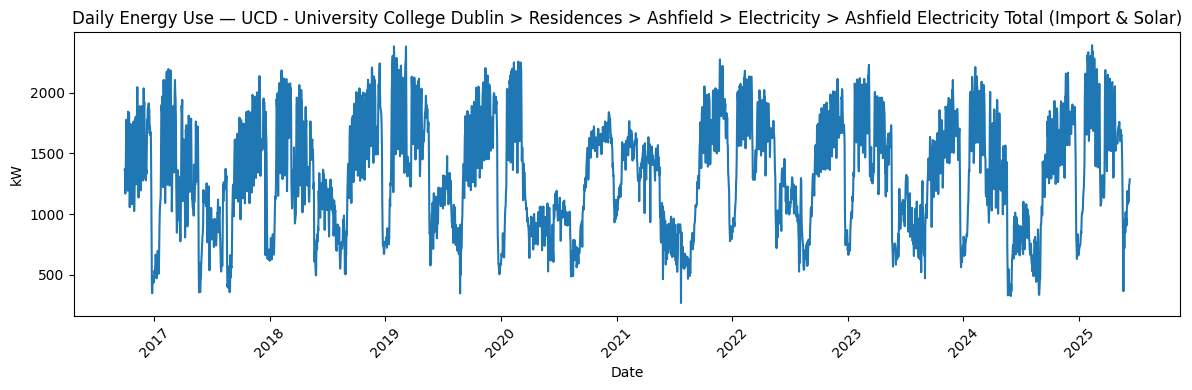

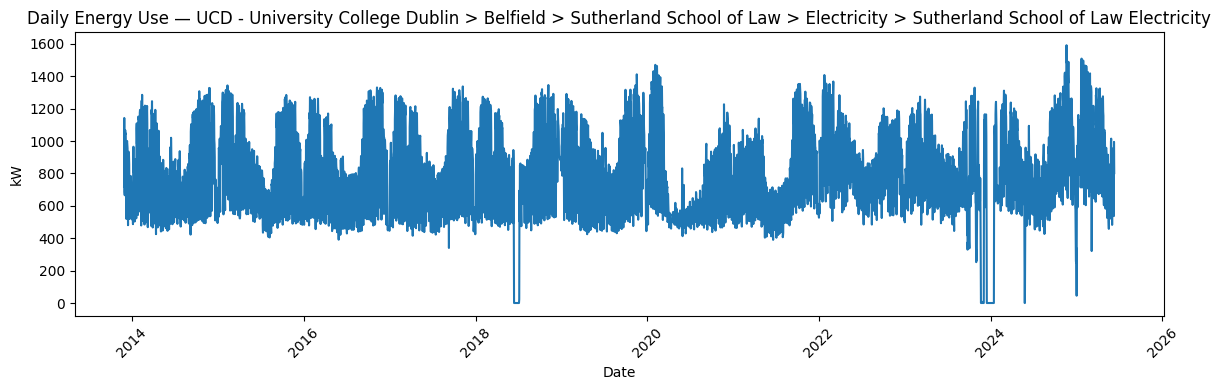

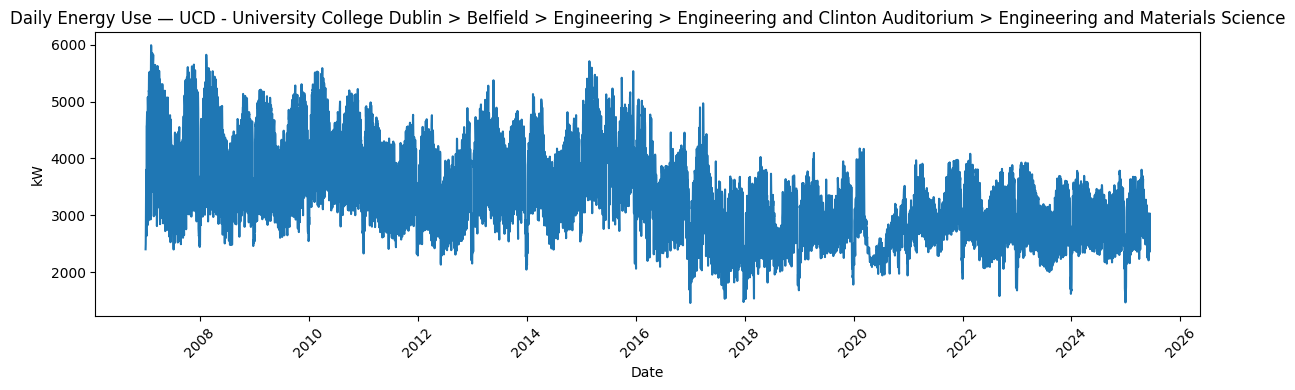

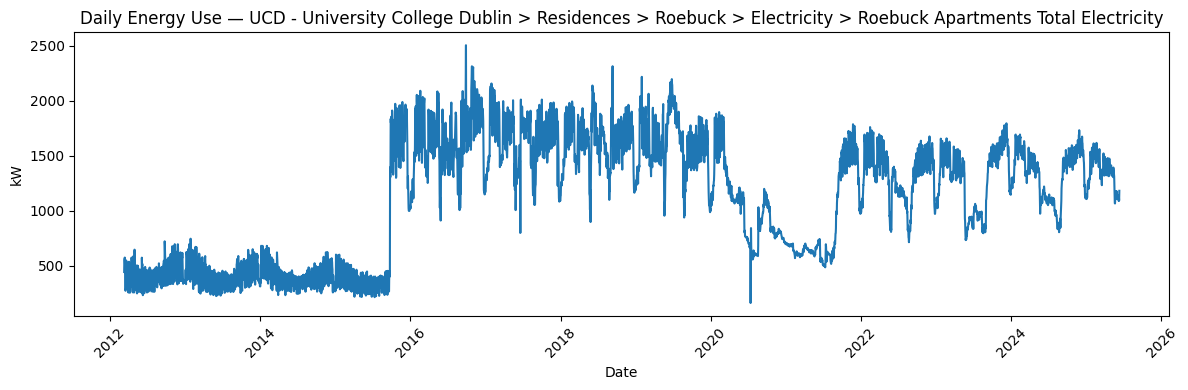

In [17]:
#Plot: Daily Energy Usage Trend
for building in buildings:
    subset = daily_summary_filtered[daily_summary_filtered["building_name"] == building]
    if subset.empty:
        continue

    plt.figure(figsize=(12, 4))
    sns.lineplot(data=subset, x="Date", y="total_kW")
    plt.title(f"Daily Energy Use — {building}")
    plt.xticks(rotation=45)
    plt.ylabel("kW")
    plt.tight_layout()
    plt.show()

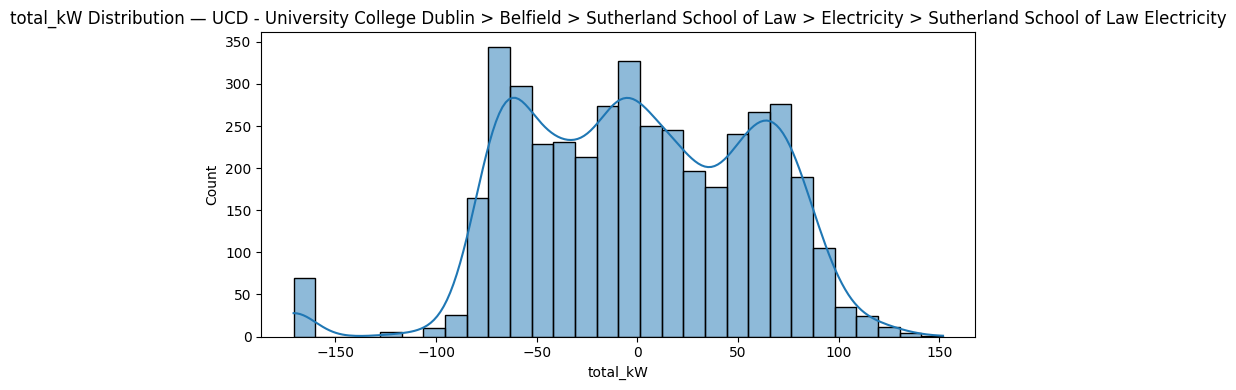

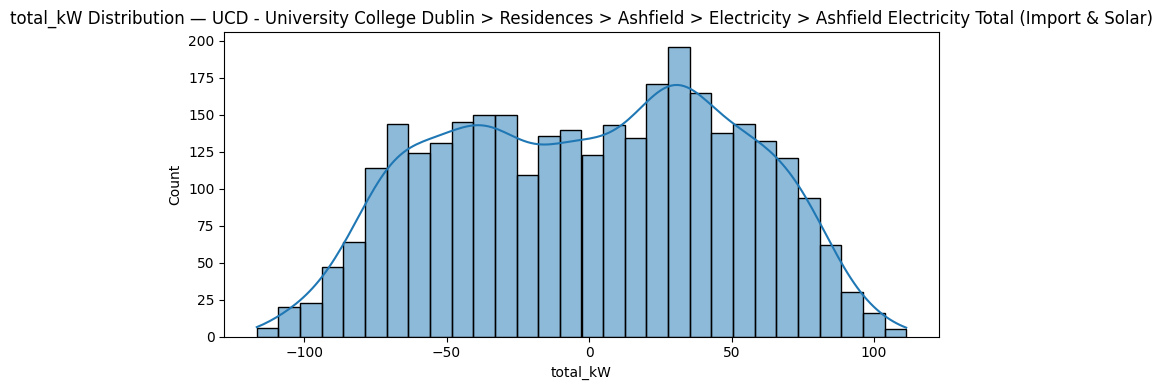

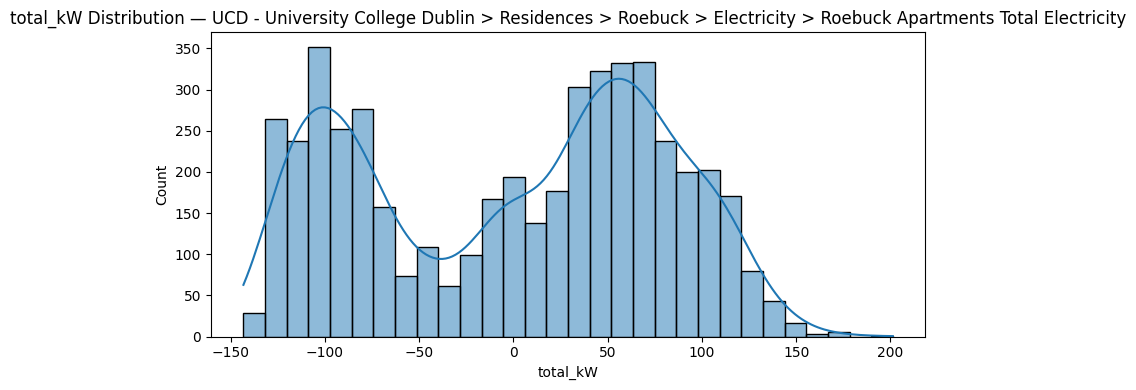

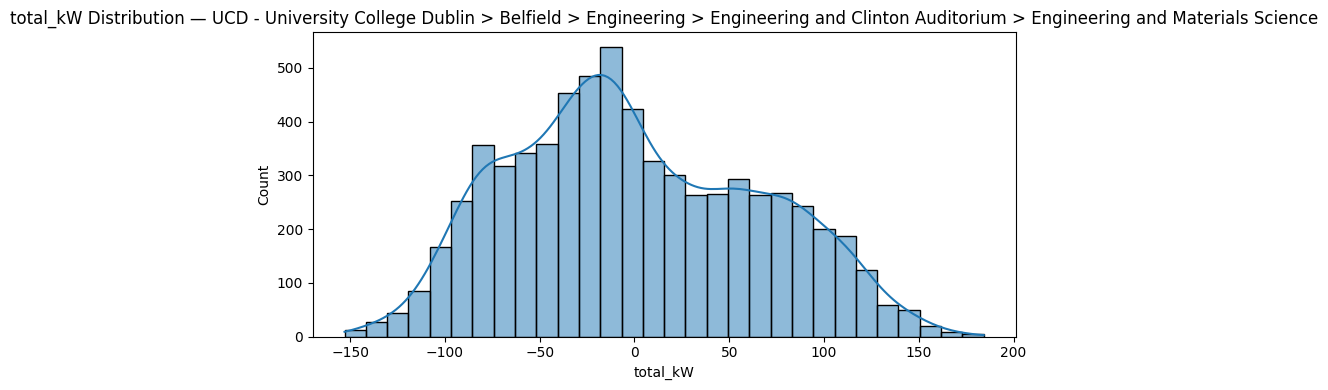

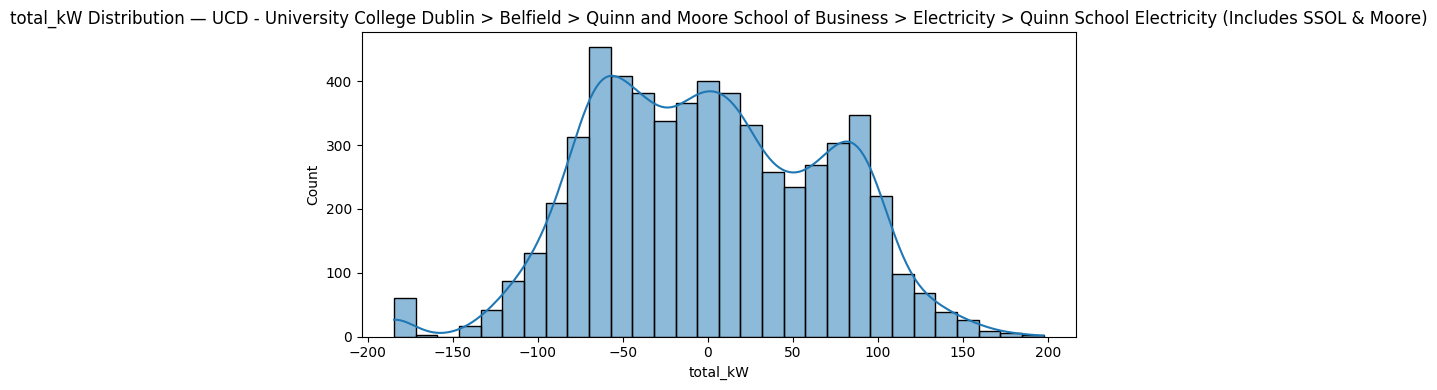

In [29]:
#Plot: Load Factor Distribution
for building in buildings:
    subset = daily_summary_filtered[daily_summary_filtered["building_name"] == building]
    if subset.empty:
        continue

    plt.figure(figsize=(8, 4))
    sns.histplot(data=subset, x="total_kW", kde=True, bins=30)
    plt.title(f"total_kW Distribution — {building}")
    plt.xlabel("total_kW")
    plt.tight_layout()
    plt.show()

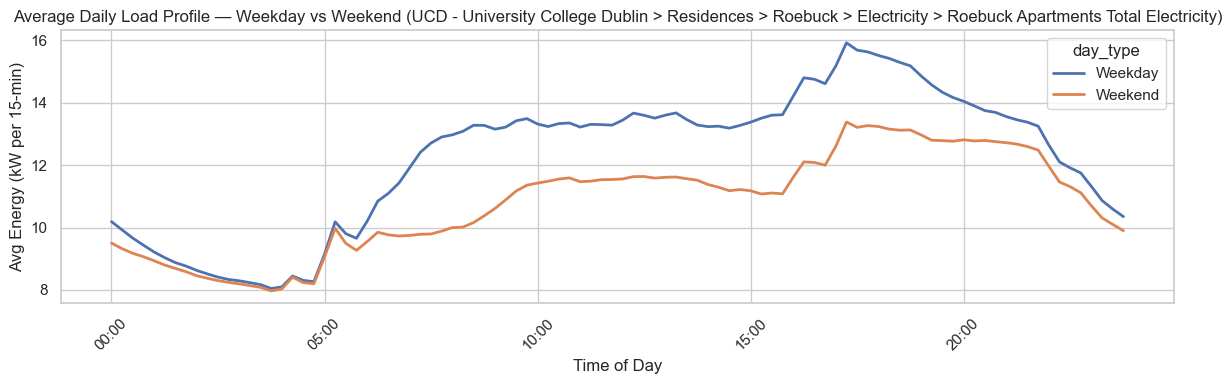

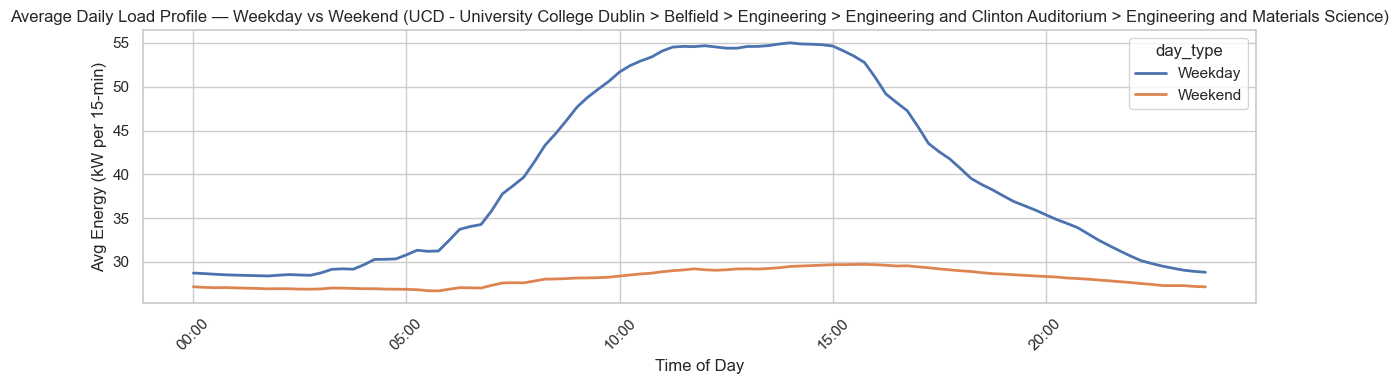

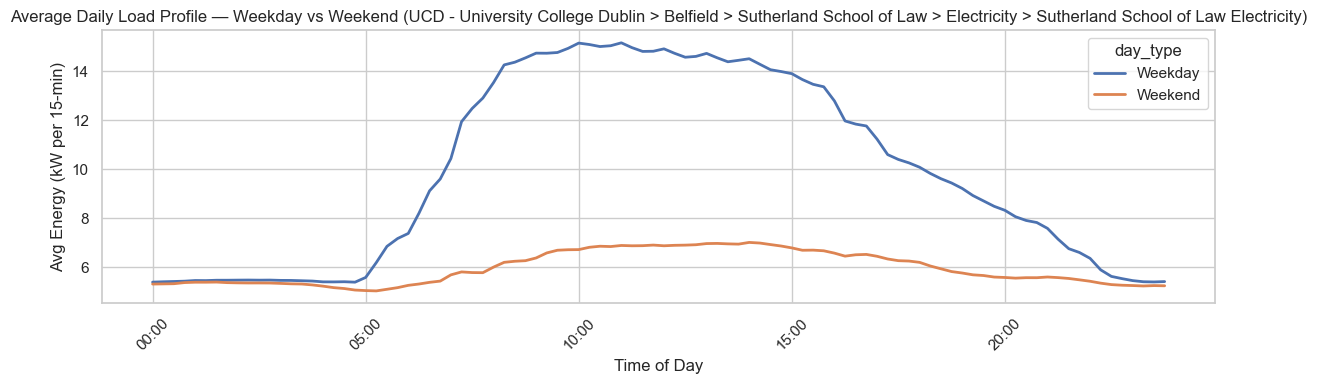

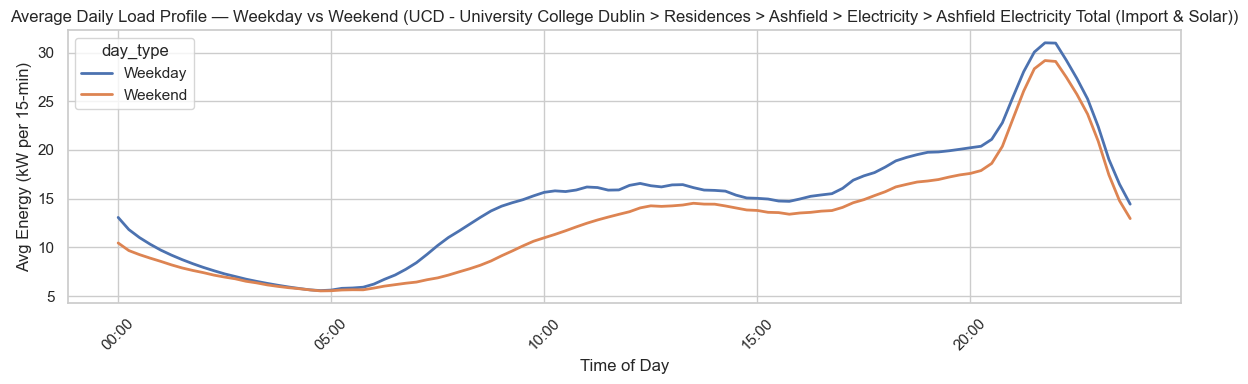

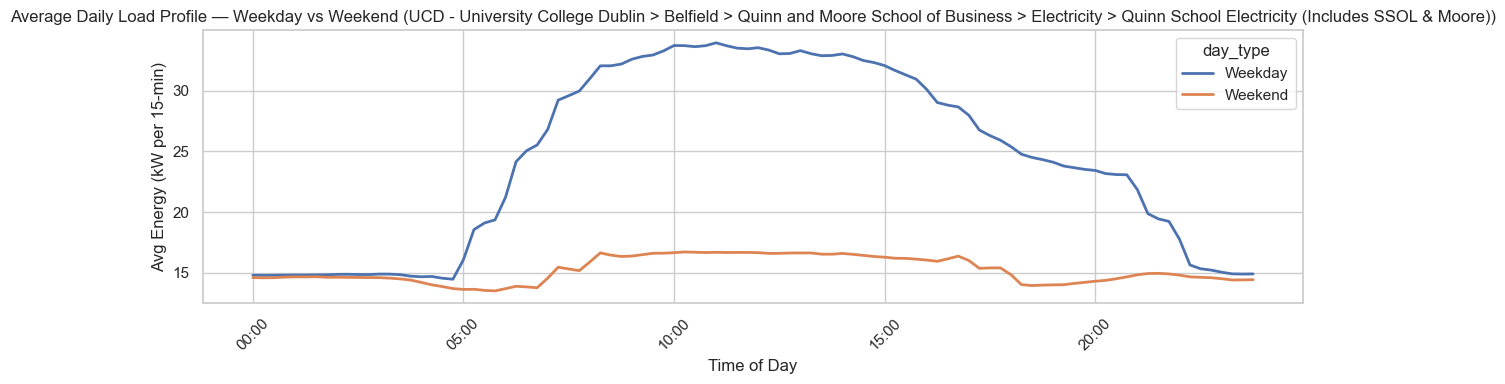

In [45]:
#Weekday vs Weekend Load Profile
for building in buildings:
    building_df = df_filtered[df_filtered["building_name"] == building]
    if building_df.empty:
        continue

    avg_profile = building_df.groupby(["time", "day_type"])["energy_kw"].mean().reset_index()
    pivoted = avg_profile.pivot(index="time", columns="day_type", values="energy_kw")

    plt.figure(figsize=(12, 4))
    pivoted.plot(ax=plt.gca(), linewidth=2)
    plt.title(f"Average Daily Load Profile — Weekday vs Weekend ({building})")
    plt.xlabel("Time of Day")
    plt.ylabel("Avg Energy (kW per 15-min)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

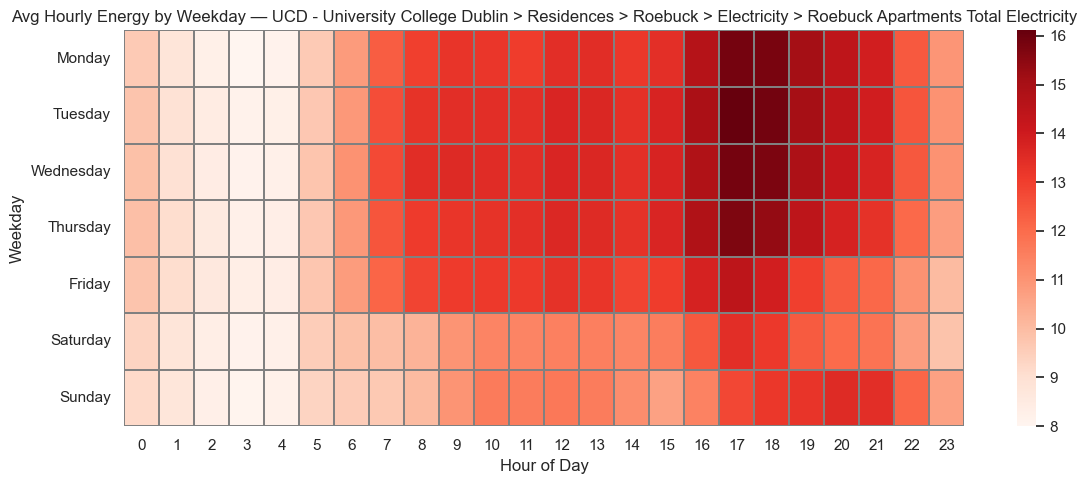

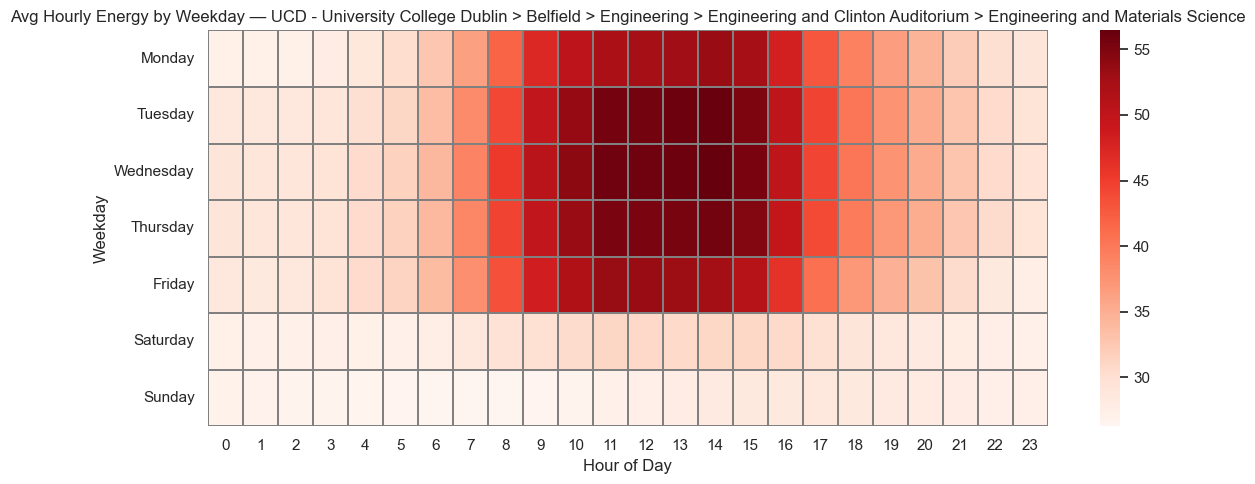

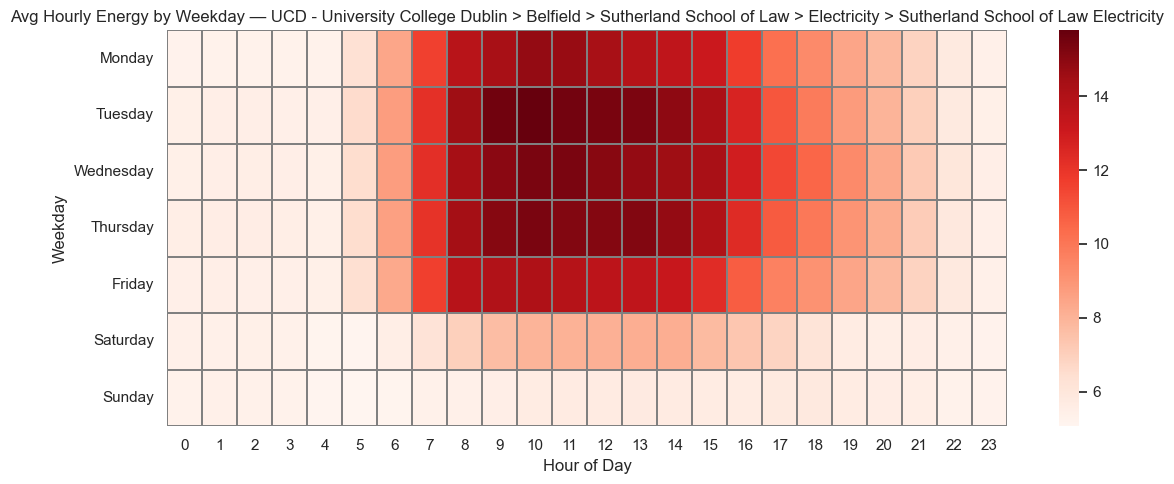

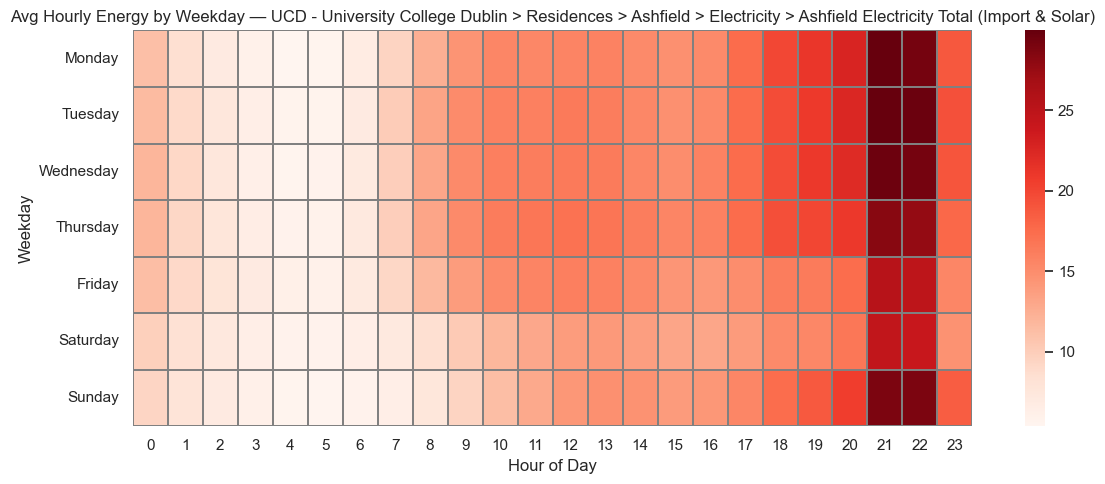

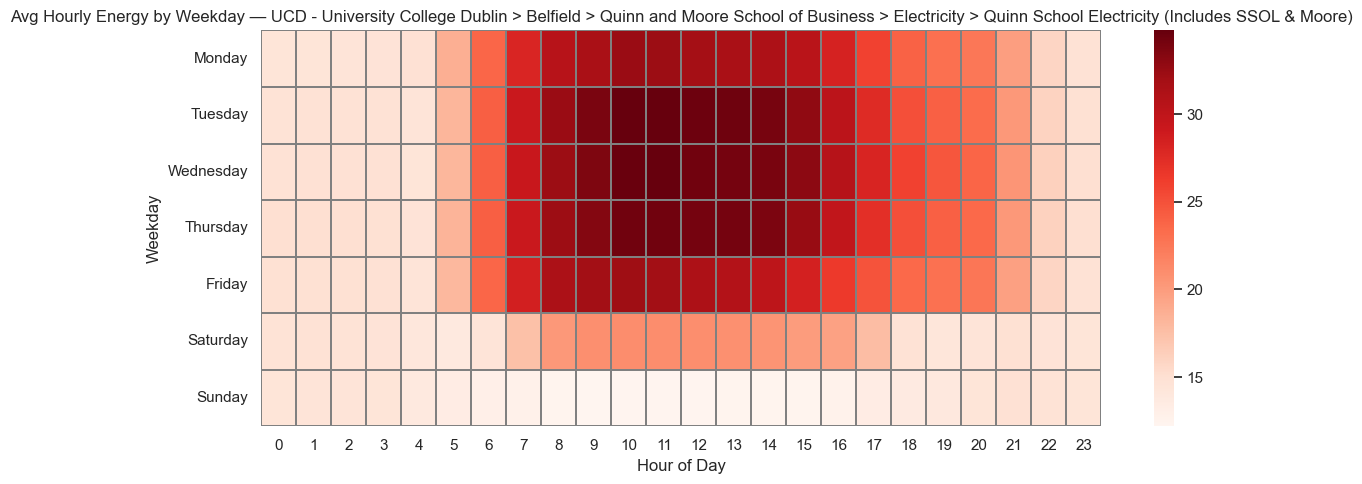

In [46]:
#Plot: Average Energy by Weekday & Hour
for building in buildings:
    building_df = df_filtered[df_filtered["building_name"] == building]
    if building_df.empty:
        continue

    heatmap_data = building_df.groupby(["Weekday", "Hour"])["energy_kw"].mean().reset_index()

    # Ensure proper weekday order
    heatmap_data["Weekday"] = pd.Categorical(
        heatmap_data["Weekday"],
        categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        ordered=True
    )

    pivot = heatmap_data.pivot(index="Weekday", columns="Hour", values="energy_kw")

    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot, cmap="Reds", linewidths=0.3, linecolor="gray", annot=False)
    plt.title(f"Avg Hourly Energy by Weekday — {building}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Weekday")
    plt.tight_layout()
    plt.show()

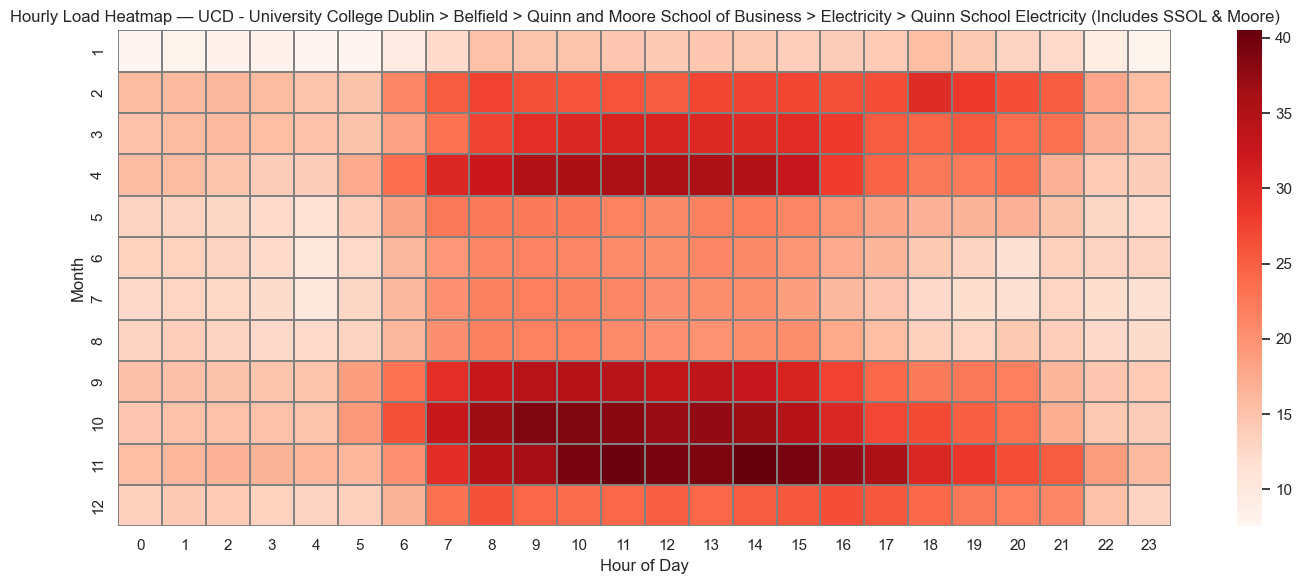

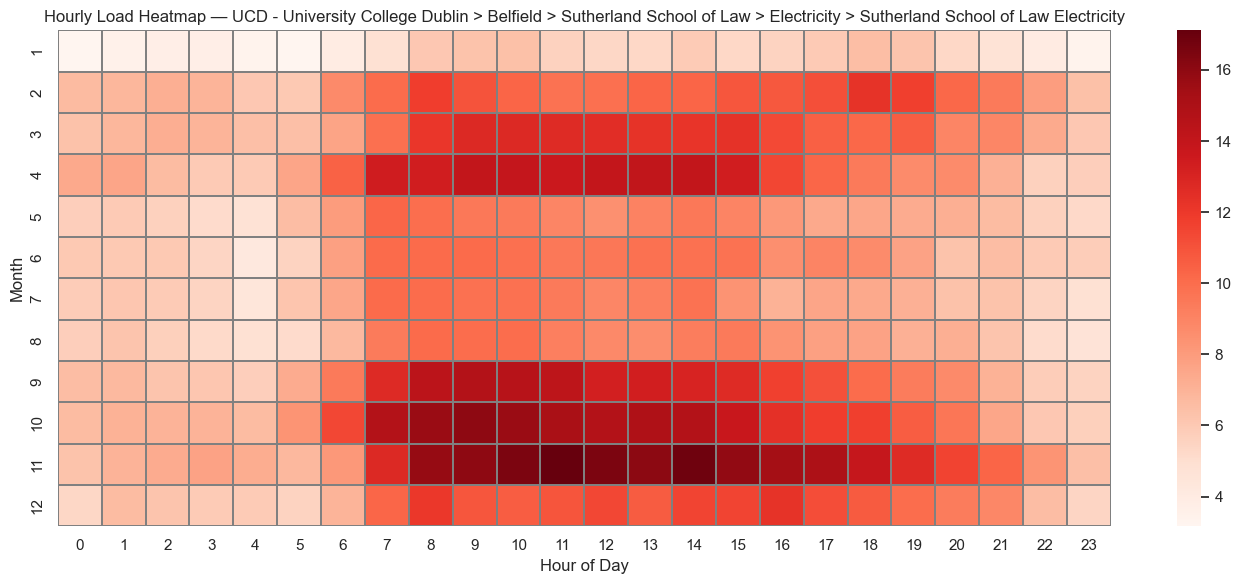

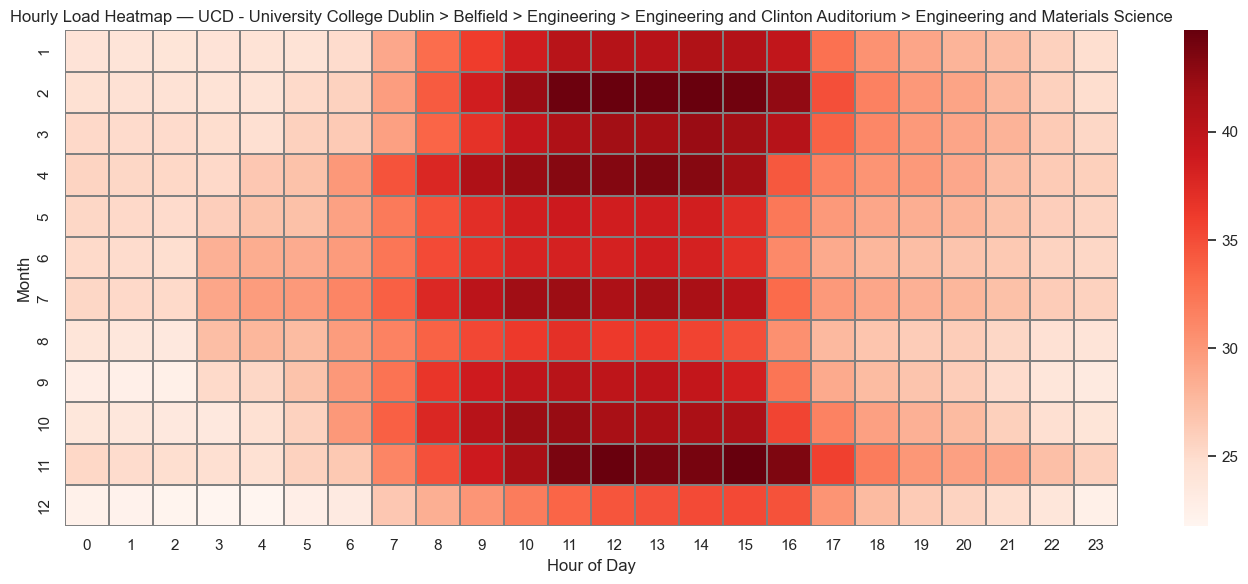

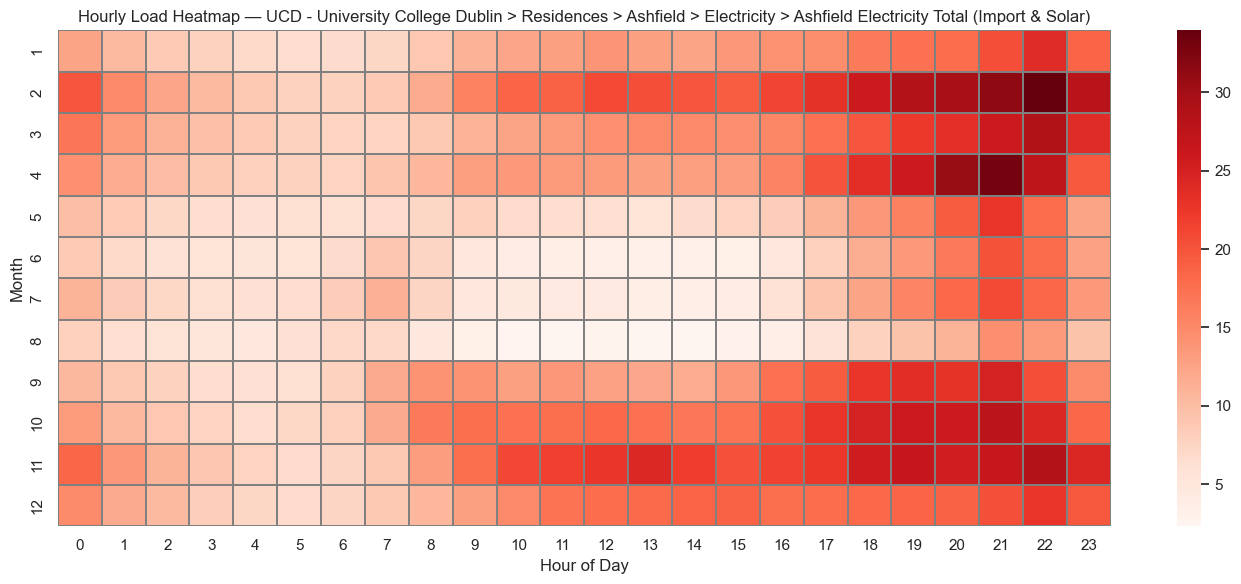

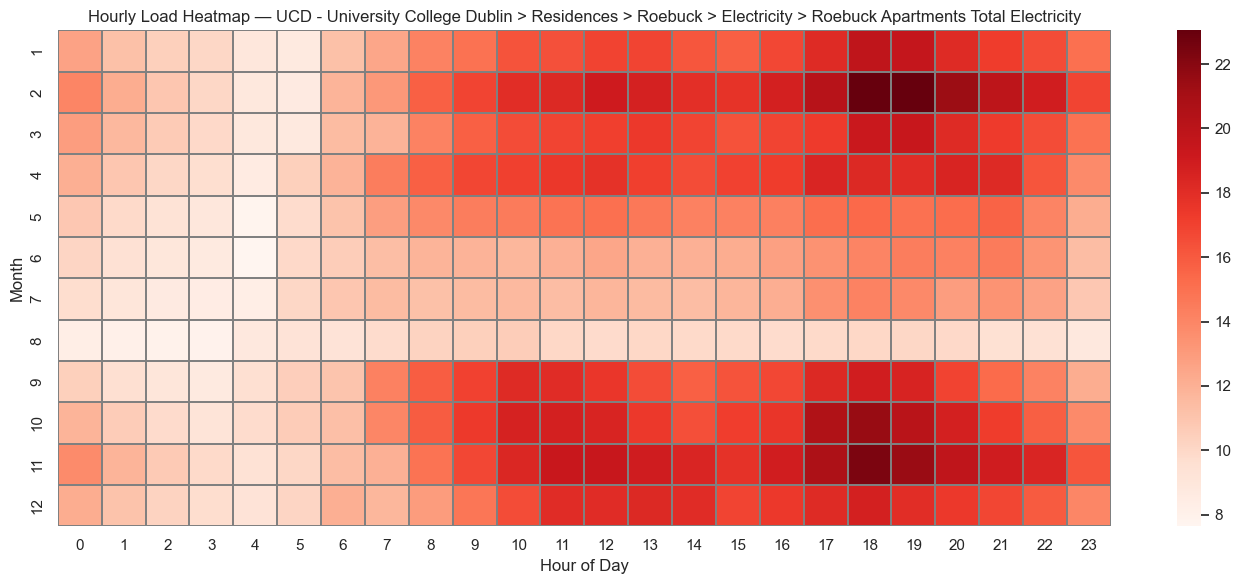

In [47]:
import calendar

# Step 2: Define filters
target_year = 2024
target_campus = "Belfield"

# Step 3: Loop through each calendar month in the year

    
filtered_df = consumption_df[
    (consumption_df["Year"] == target_year) & (consumption_df["campus"] == target_campus)
]

buildings = filtered_df["building_name"].unique()

for building in buildings:
    building_df = filtered_df[filtered_df["building_name"] == building]
    
    if building_df.empty:
        continue

# Step 4: Group and pivot
    heatmap_data = building_df.groupby(["Month", "Hour"])["energy_kw"].mean().reset_index()
    pivot = heatmap_data.pivot(index="Month", columns="Hour", values="energy_kw")

    # Step 5: Plot
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot, cmap="Reds", linewidths=0.3, linecolor="gray", annot=False)
    plt.title(f"Hourly Load Heatmap — {building}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()

In [48]:
net = pd.merge(
    consumption_df[consumption_df['building_v1'].isin(['ashfield', 'engineering_engineering'])],
    pv_df[['Datetime', 'building_v1', 'energy_kw']][pv_df['building_v1'].isin(['ashfield', 'engineering_engineering'])],
    on=["Datetime", "building_v1"],
    how='left',
    suffixes=('', '_pv')
)

net[['energy_kw', 'energy_kw_pv']] = net[['energy_kw', 'energy_kw_pv']].fillna(0)

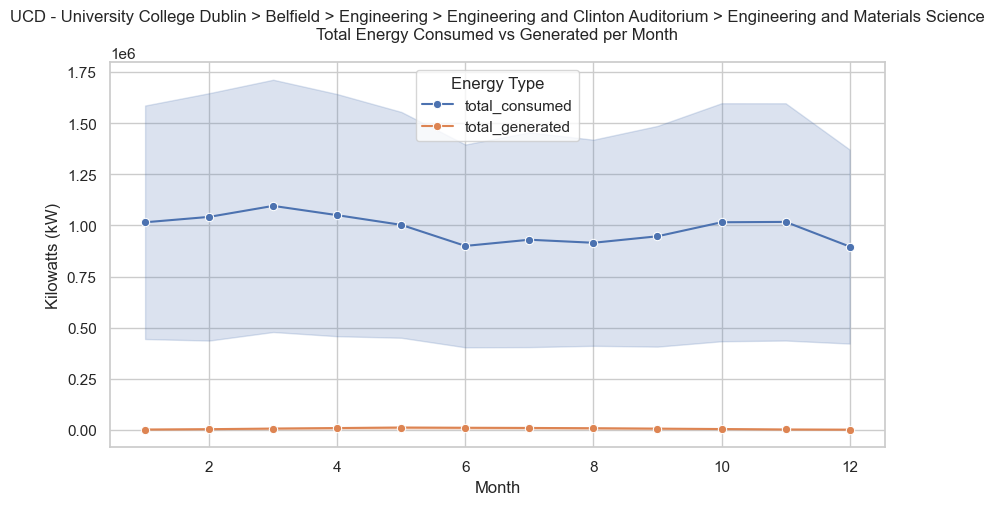

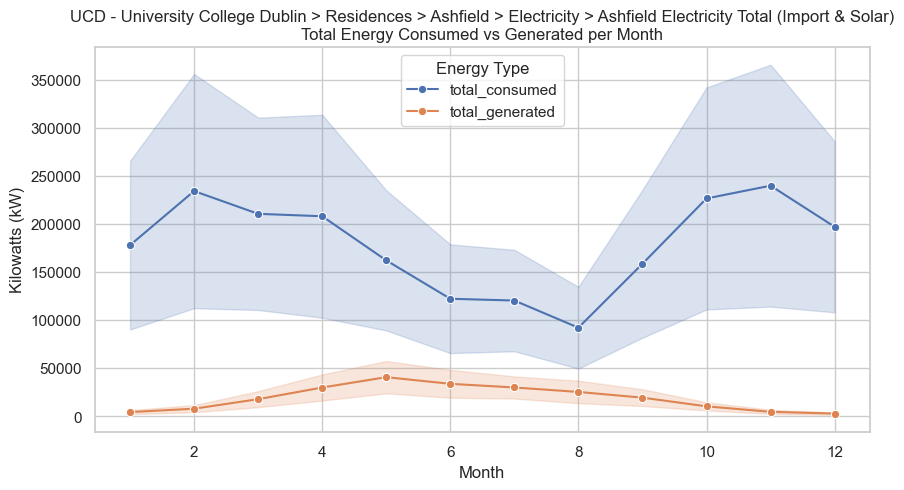

In [49]:
daily_consumption = net.groupby(['Month', "building_name", "day_type"]).agg(
    total_consumed=("energy_kw", "sum"),
    total_generated=("energy_kw_pv", "sum")
).reset_index()

for building in daily_consumption["building_name"].unique():
    building_df = daily_consumption[daily_consumption["building_name"] == building].drop(columns=["building_name", "day_type"])
    if building_df.empty:
        continue

    df_melted = building_df.melt(id_vars="Month", var_name="Type", value_name="Kilowatts")

    # Set Seaborn theme
    sns.set_theme(style="whitegrid")

    # Create line plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_melted, x="Month", y="Kilowatts", hue="Type", marker="o")

    # Labels and title
    plt.xlabel("Month")
    plt.ylabel("Kilowatts (kW)")
    plt.title(f"{building}\nTotal Energy Consumed vs Generated per Month")
    plt.legend(title="Energy Type")

    # Show the plot
    plt.show()


In [50]:
for x in daily_consumption["building_name"].unique():
    print(x)

UCD - University College Dublin > Belfield > Engineering > Engineering and Clinton Auditorium > Engineering and Materials Science
UCD - University College Dublin > Residences > Ashfield > Electricity > Ashfield Electricity Total (Import & Solar)


In [51]:
import matplotlib.pyplot as plt
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

paa_segments = 12
alphabet_size = 5

subset = daily_consumption[daily_consumption["building_name"] == 'UCD - University College Dublin > Belfield > Engineering > Engineering and Clinton Auditorium > Engineering and Materials Science']
subset = subset.groupby("Month")["total_consumed"].sum().reset_index().sort_values("Month")

months = subset["Month"].values
energy = subset["total_consumed"].values

# Normalize energy
norm_energy = (energy - energy.mean()) / energy.std()

# === SAX Encoding ===
paa_rep = paa(norm_energy, paa_segments)
cuts = cuts_for_asize(alphabet_size)
sax_string = ts_to_string(paa_rep, cuts)
sax_numeric = [ord(symbol) - ord('a') for symbol in sax_string]


--- UCD - University College Dublin > Belfield > Engineering > Engineering and Clinton Auditorium > Engineering and Materials Science ---
Original Energy (kWh): [2031284.72806539 2084110.29753899 2191750.83253428 2100916.52760123
 2006068.88890187 1800072.51649347 1860569.62186273 1830846.00703516
 1894339.80581347 2031565.47436891 2035009.65122848 1793918.79510804]
Normalized Energy: [ 0.47435148  0.89492485  1.75191027  1.02872848  0.27359434 -1.36645591
 -0.88480523 -1.12145125 -0.61594225  0.47658666  0.50400764 -1.41544907]
PAA Representation: [ 0.47435148  0.89492485  1.75191027  1.02872848  0.27359434 -1.36645591
 -0.88480523 -1.12145125 -0.61594225  0.47658666  0.50400764 -1.41544907]
SAX String: deeedaaabdda
SAX Numeric: [3, 4, 4, 4, 3, 0, 0, 0, 1, 3, 3, 0]
PCA Projection: [ 0.47435148  0.89492485  1.75191027  1.02872848  0.27359434 -1.36645591
 -0.88480523 -1.12145125 -0.61594225  0.47658666  0.50400764 -1.41544907]


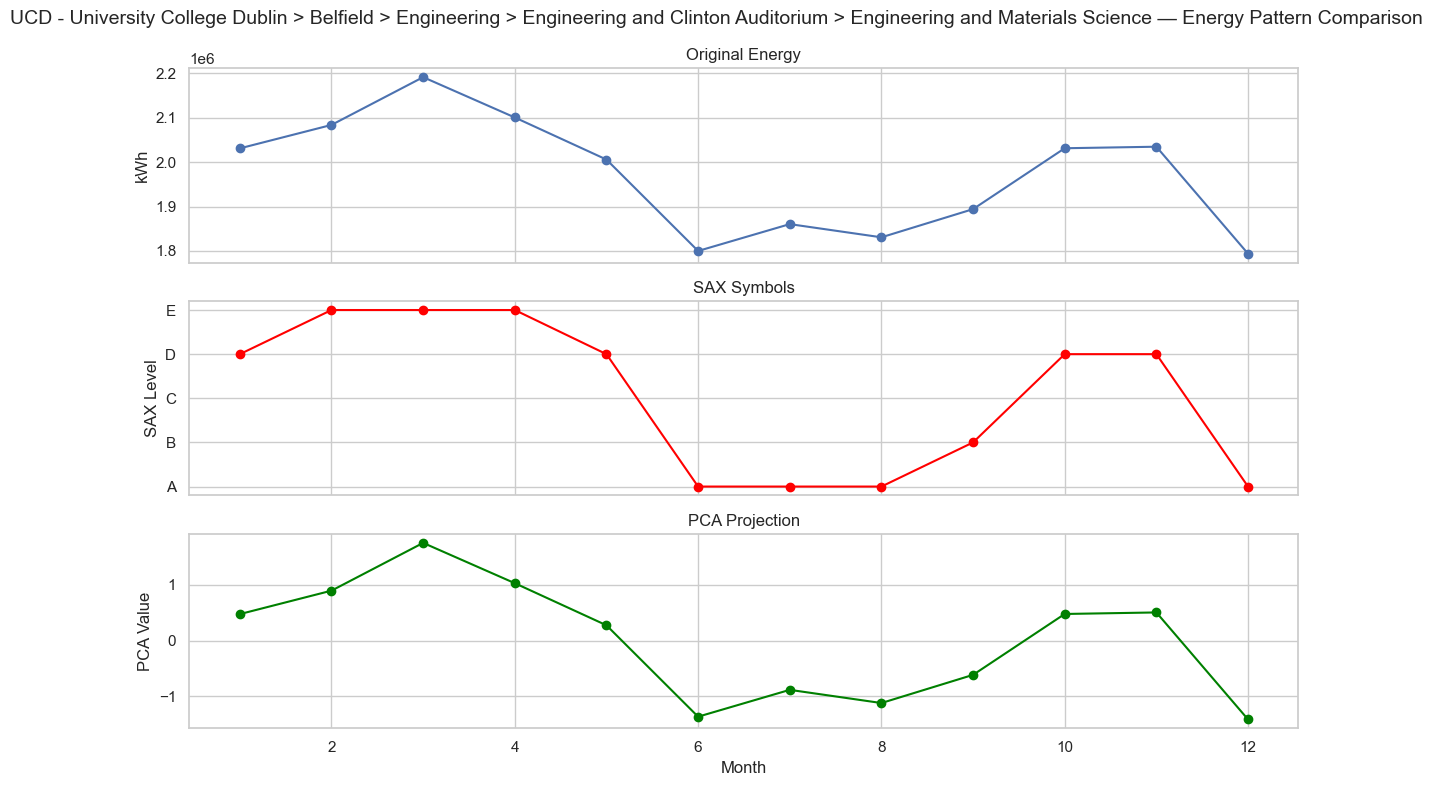


--- UCD - University College Dublin > Residences > Ashfield > Electricity > Ashfield Electricity Total (Import & Solar) ---
Original Energy (kWh): [355966.75183196 468410.06815257 421088.88090351 416083.73332966
 324367.85337125 244558.19959594 240886.88194554 184432.49094353
 317301.98572399 453019.44545508 479637.62347718 394166.97039235]
Normalized Energy: [-0.02532877  1.18147811  0.67359969  0.61988154 -0.36446647 -1.22102995
 -1.26043266 -1.86633392 -0.44030146  1.01629702  1.30197874  0.38465813]
PAA Representation: [-0.02532877  1.18147811  0.67359969  0.61988154 -0.36446647 -1.22102995
 -1.26043266 -1.86633392 -0.44030146  1.01629702  1.30197874  0.38465813]
SAX String: ceddbaaabeed
SAX Numeric: [2, 4, 3, 3, 1, 0, 0, 0, 1, 4, 4, 3]
PCA Projection: [-0.02532877  1.18147811  0.67359969  0.61988154 -0.36446647 -1.22102995
 -1.26043266 -1.86633392 -0.44030146  1.01629702  1.30197874  0.38465813]


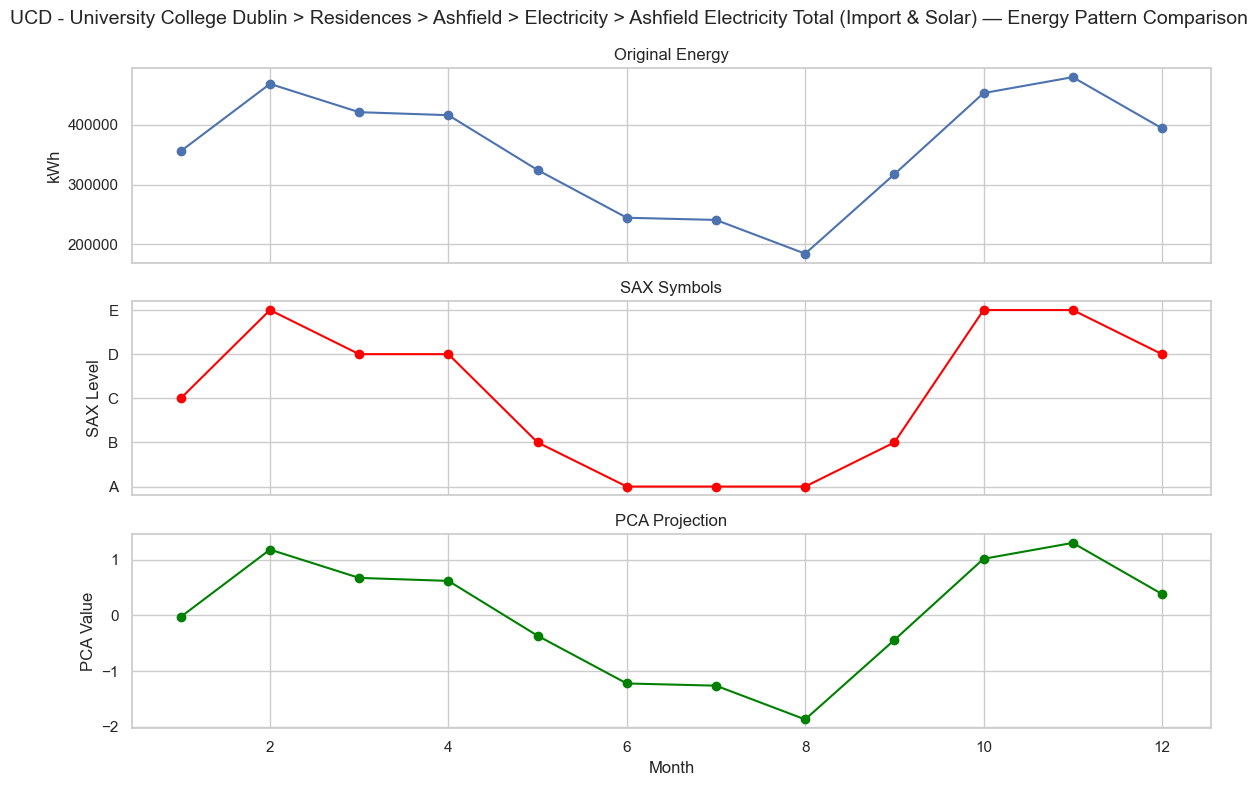

In [52]:
import matplotlib.pyplot as plt
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set parameters
paa_segments = 12
alphabet_size = 5

# Loop through each building
for building in daily_consumption["building_name"].unique():
    # Aggregate total monthly consumption
    subset = daily_consumption[daily_consumption["building_name"] == building]
    subset = subset.groupby("Month")["total_consumed"].sum().reset_index().sort_values("Month")

    if subset.shape[0] < 12:
        continue

    months = subset["Month"].values
    energy = subset["total_consumed"].values

    # Normalize energy
    norm_energy = (energy - energy.mean()) / energy.std()

    # === SAX Encoding ===
    paa_rep = paa(norm_energy, paa_segments)
    cuts = cuts_for_asize(alphabet_size)
    sax_string = ts_to_string(paa_rep, cuts)
    sax_numeric = [ord(symbol) - ord('a') for symbol in sax_string]

    # === PCA Transformation ===
    scaler = StandardScaler()
    energy_scaled = scaler.fit_transform(energy.reshape(-1, 1))
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(energy_scaled).flatten()
    
    # === Debugging Output ===
    print(f"\n--- {building} ---")
    print("Original Energy (kWh):", energy)
    print("Normalized Energy:", norm_energy)
    print("PAA Representation:", paa_rep)
    print("SAX String:", sax_string)
    print("SAX Numeric:", sax_numeric)
    print("PCA Projection:", pca_result)

    # === Plot ===
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"{building} — Energy Pattern Comparison", fontsize=14)

    axs[0].plot(months, energy, marker='o')
    axs[0].set_title("Original Energy")
    axs[0].set_ylabel("kWh")

    axs[1].plot(months[:paa_segments], sax_numeric, marker='o', color='red')
    axs[1].set_yticks(range(alphabet_size))
    axs[1].set_yticklabels([chr(ord('A') + i) for i in range(alphabet_size)])
    axs[1].set_title("SAX Symbols")
    axs[1].set_ylabel("SAX Level")

    axs[2].plot(months, pca_result, marker='o', color='green')
    axs[2].set_title("PCA Projection")
    axs[2].set_ylabel("PCA Value")
    axs[2].set_xlabel("Month")

    plt.tight_layout()
    plt.show()